In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates
from pandas.api.types import is_numeric_dtype

# Deliverables
1. Research Question
    - Can we predict the S&P price over the next 10 days using financial indicators?
3. Hypothesis
    - Null: There are no correlations
    - Alternative: There are correlations

In [2]:
bond_yield_df = pd.read_csv("Bond yield.csv")
cpi_df = pd.read_csv("Consumer price index.csv")
dj_df = pd.read_csv("Dow Jones.csv")
usd_eur_df = pd.read_csv("USD_EUR.csv")
usd_jpy_df = pd.read_csv("USD_JPY.csv")
gdp_df = pd.read_csv("GDP.csv")
national_hpi_df = pd.read_csv("National home price index.csv")
sp_df = pd.read_csv("S&P Price.csv")

dfs = [bond_yield_df, cpi_df, dj_df, usd_eur_df, usd_jpy_df, gdp_df, national_hpi_df, sp_df]

In [3]:
for i in range(len(dfs)):
    dfs[i].columns.values[0] = 'date'
    dfs[i] = dfs[i].drop_duplicates(subset="date", keep="first") 
    
    dfs[i].set_index('date', inplace=True)
    dfs[i].index = pd.to_datetime(dfs[i].index, errors="coerce").normalize()

    dfs[i] = dfs[i][~dfs[i].index.duplicated(keep="first")]
    


In [4]:
merged_df = pd.concat(dfs, axis=1)

In [5]:
df = merged_df[['Value', 'DJIA', 'GDP', 'DGS10', 'CSUSHPINSA', 'CPIAUCSL', 'EURO', 'JPY']]
df.columns = ['SP_price','dow_jones','gdp','bond_yield','home_price_index','consumer_price_index','eur','jpy']

df.reset_index(inplace=True)
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
df.set_index("date", inplace=True) 
df = df.reindex(full_date_range)
df.index.name = "date"

df= df.fillna(method='ffill')



C:\Users\wachic\AppData\Local\Temp\ipykernel_28184\3284340131.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df= df.fillna(method='ffill')


In [6]:
def insert_mirrored_rows(df, num_rows=30):
    """
    Insert chronologically mirrored data point at head and tail of df
    """
    df = df.copy()
    mirrored_rows_head = df.iloc[:num_rows].copy()
    mirrored_rows_head = mirrored_rows_head.iloc[::-1].reset_index(drop=True)

    mirrored_rows_tail = df.iloc[-num_rows:].copy()
    mirrored_rows_tail = mirrored_rows_tail.iloc[::-1].reset_index(drop=True)

    df_extended = pd.concat([mirrored_rows_head, df, mirrored_rows_tail], ignore_index=True)
    
    return df_extended

In [7]:
df['SP_price_ln'] = np.log(df['SP_price'])
df['dow_jones'] = pd.to_numeric(df['dow_jones'].str.replace(',', '', regex=True))

extended_df = insert_mirrored_rows(df['SP_price'].copy(), 200)
df.dtypes

SP_price                float64
dow_jones               float64
gdp                     float64
bond_yield              float64
home_price_index        float64
consumer_price_index    float64
eur                     float64
jpy                     float64
SP_price_ln             float64
dtype: object

In [8]:
ma30_df = df.rolling(window=30).mean().reset_index().iloc[30:-30].reset_index(drop=True)
ma100_df = df.rolling(window=100).mean().reset_index().iloc[100:-100].reset_index(drop=True)
ma200_df = df.rolling(window=200).mean().reset_index().iloc[200:-200].reset_index(drop=True)
df['SP_MA_30'] = ma30_df['SP_price']
df['SP_MA_100'] = ma100_df['SP_price']
df['SP_MA_200'] = ma200_df['SP_price']

In [9]:

df.reset_index(inplace=True)  # Move the index back to a column
df.head(500)


,date,SP_price,dow_jones,gdp,bond_yield,home_price_index,consumer_price_index,eur,jpy,SP_price_ln,SP_MA_30,SP_MA_100,SP_MA_200
0,1927-12-30,17.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.871302,NaN,NaN,NaN
1,1927-12-31,17.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.871302,NaN,NaN,NaN
2,1928-01-01,17.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.871302,NaN,NaN,NaN
3,1928-01-02,17.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.871302,NaN,NaN,NaN
4,1928-01-03,17.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.876949,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1929-05-08,26.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.264996,NaN,NaN,NaN
496,1929-05-09,26.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.258865,NaN,NaN,NaN
497,1929-05-10,26.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.271089,NaN,NaN,NaN
498,1929-05-11,26.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.271089,NaN,NaN,NaN


Locator attempting to generate 1284 ticks ([-17108.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1284 ticks ([-17108.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1284 ticks ([-17108.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1284 ticks ([-17108.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1284 ticks ([-17108.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1284 ticks ([-17108.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1284 ticks ([-17108.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1284 ticks ([-17108.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1284 ticks ([-17108.0, ..., 21946.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting 

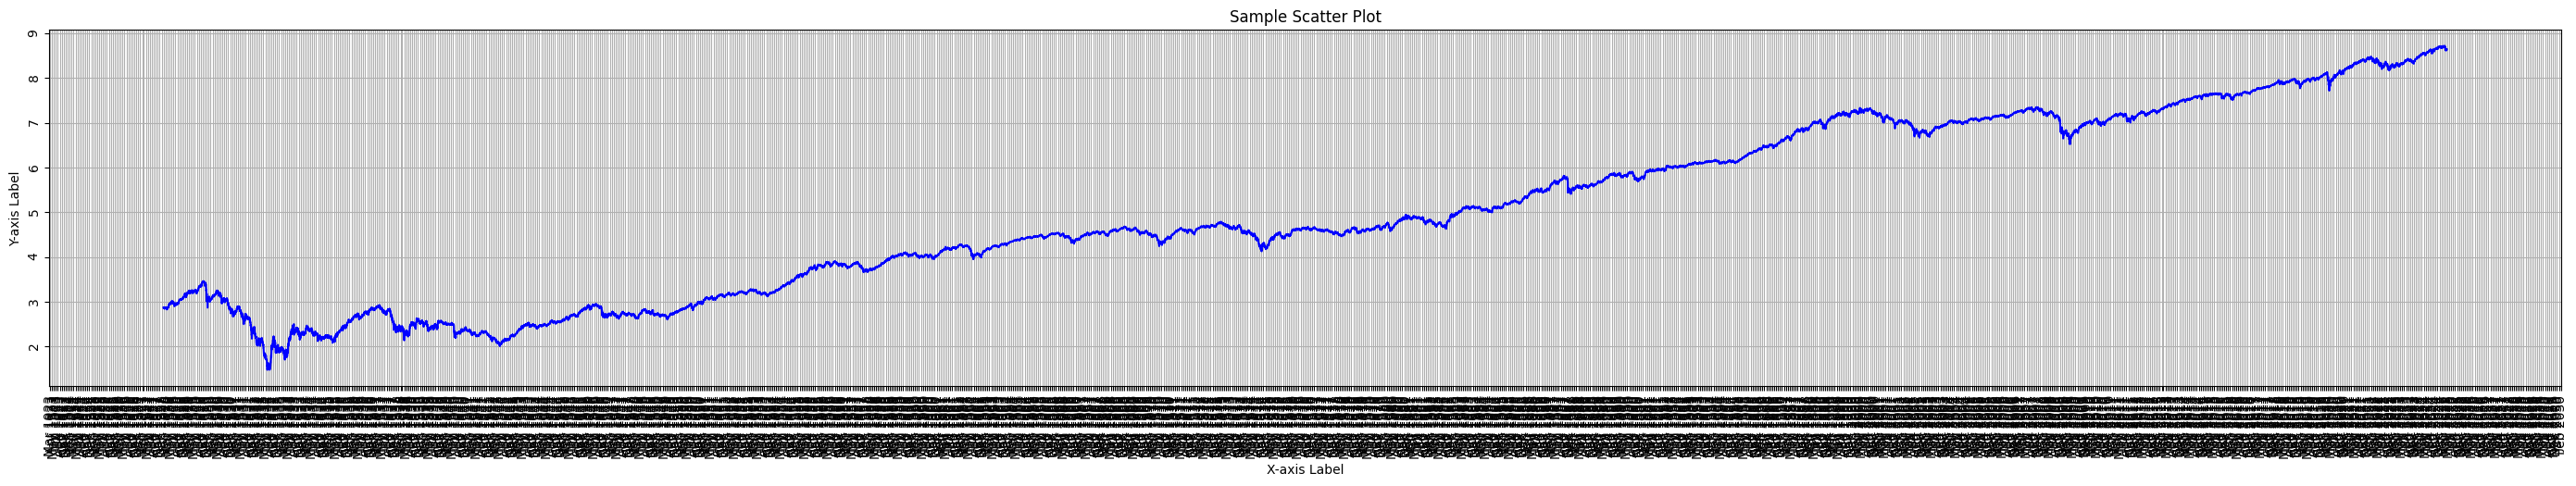

In [10]:
plt.figure(figsize=(35, 5))
plt.plot(df['date'], df['SP_price_ln'], linestyle='-', color='b', markersize=6, label="Data Line")
# Add labels and title

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')

plt.xticks(rotation=90)
plt.yticks(rotation=90)

plt.title('Sample Scatter Plot')

plt.grid(True)

plt.show()

In [11]:
df_first_of_month = df[df['date'].dt.day == 1]

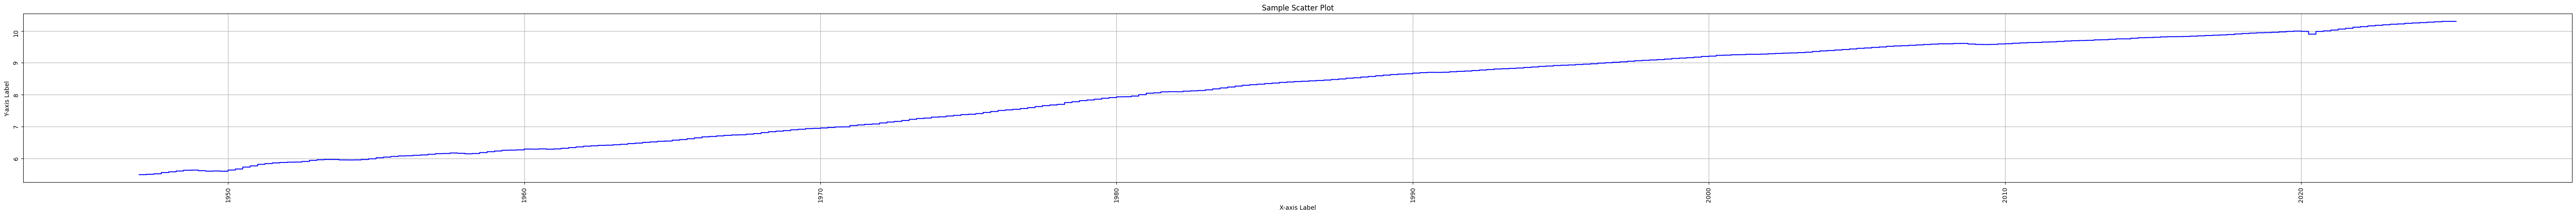

In [15]:
plt.figure(figsize=(75, 5))

plt.plot(df['date'], np.log(df['gdp']), linestyle='-', color='b', markersize=6, label="Data Line")
# Add labels and title

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')

plt.xticks(rotation=90)
plt.yticks(rotation=90)

plt.title('Sample Scatter Plot')

plt.grid(True)
# Show color bar

# Show the plot
plt.show()

In [13]:
# csv = df.to_csv('Combined df.csv', index = False) 
